In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets_utils
import nanonets

In [3]:
# folder  = "/mnt/c/Users/jonas/Desktop/phd/data/"
folder  = "/home/jonas/phd/data/"
N_seeds = 36

# Load Data
df      = pd.read_csv(folder+"system_size/scaled/Nx=7_Ny=7_Nz=1_Ne=8.csv")
df_res  = pd.DataFrame()
df_rad  = pd.DataFrame()
for seed in range(N_seeds):
    df_res = pd.concat([df_res, pd.read_csv(folder+f'ndr_nls_disorder/resistance/Nx=7_Ny=7_Nz=1_Ne=8_th={seed}.csv')], ignore_index=True)
    df_rad = pd.concat([df_rad, pd.read_csv(folder+f'ndr_nls_disorder/radius/Nx=7_Ny=7_Nz=1_Ne=8_th={seed}.csv')], ignore_index=True)

# Rename Columns
columns = ['C1','I1','C2','I2','C3','C4','C5','O','G','Eq_Jumps','Jumps','Current','Error']
df.columns      = columns
df_res.columns  = columns
df_rad.columns  = columns

# Neglect high errors?
min_error   = 0.0
max_error   = 0.5
df          = df[(np.round(df['Error']/df['Current'].abs(),2) >= min_error) & (np.round(df['Error']/df['Current'].abs(),2) < max_error)].reset_index(drop=True)
df_res      = df_res[(np.round(df_res['Error']/df_res['Current'].abs(),2) >= min_error) & (np.round(df_res['Error']/df_res['Current'].abs(),2) < max_error)].reset_index(drop=True)
df_rad      = df_rad[(np.round(df_rad['Error']/df_rad['Current'].abs(),2) >= min_error) & (np.round(df_rad['Error']/df_rad['Current'].abs(),2) < max_error)].reset_index(drop=True)

# Prepare Dataframe
df      = nanonets_utils.prepare_for_fitness_calculation(df=df, N_c=5, min_current=0)
df_res  = nanonets_utils.prepare_for_fitness_calculation(df=df_res, N_c=5, min_current=0)
df_rad  = nanonets_utils.prepare_for_fitness_calculation(df=df_rad, N_c=5, min_current=0)

In [4]:
gates           = ['AND','OR','XOR','NAND','NOR','XNOR']
fitness         = nanonets_utils.fitness(df=df, N_controls=5, delta=0)
abundance       = nanonets_utils.abundance(df=fitness)
fitness_res     = nanonets_utils.fitness(df=df_res, N_controls=5, delta=0)
abundance_res   = nanonets_utils.abundance(df=fitness_res)
fitness_rad     = nanonets_utils.fitness(df=df_rad, N_controls=5, delta=0)
abundance_rad   = nanonets_utils.abundance(df=fitness_rad)

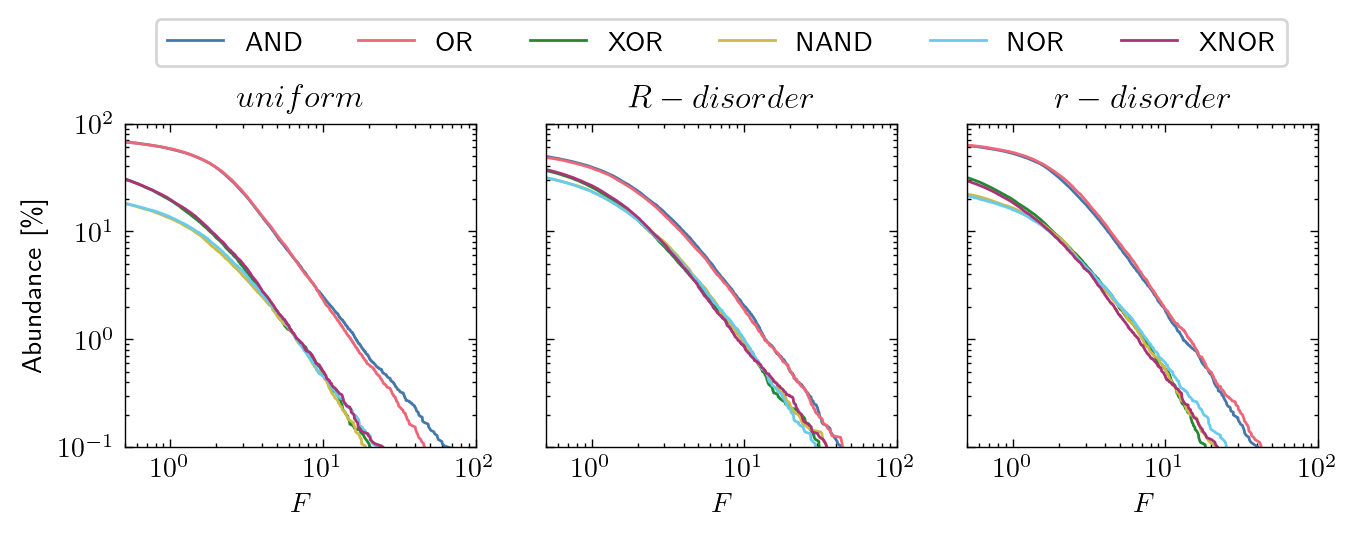

In [5]:
nrows   = 1
ncols   = 3

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2.2)
    fig.set_figheight(fig.get_figheight()*0.8)

    ax = fig.add_subplot(nrows, ncols, 1)
    ax.set_xlim(0.5,100)
    ax.set_ylim(0.1,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Abundance [\%]')
    ax.set_xlabel('$F$')
    ax.set_title('$uniform$')

    for i, gate in enumerate(gates):

        ax.plot(abundance[f'{gate} Fitness'], abundance[f'{gate} Fitness Abundance'])
    
    ax = fig.add_subplot(nrows, ncols, 2)
    ax.set_xlim(0.5,100)
    ax.set_ylim(0.1,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$F$')
    ax.set_title('$R-disorder$')
    ax.set_yticklabels("")

    for i, gate in enumerate(gates):

        ax.plot(abundance_res[f'{gate} Fitness'], abundance_res[f'{gate} Fitness Abundance'], label=gate)

    ax.legend(loc='center', bbox_to_anchor=(0.5,1.25), ncols=6, frameon=True)

    ax = fig.add_subplot(nrows, ncols, 3)
    ax.set_xlim(0.5,100)
    ax.set_ylim(0.1,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$F$')
    ax.set_title('$r-disorder$')
    ax.set_yticklabels("")

    for i, gate in enumerate(gates):

        ax.plot(abundance_rad[f'{gate} Fitness'], abundance_rad[f'{gate} Fitness Abundance'])

---

In [6]:
fitness_melt                    = pd.melt(fitness.loc[:,'AND Fitness':], var_name='Gate', value_name='$F$')
fitness_melt['Disorder']        = '$uniform$'
fitness_melt_res                = pd.melt(fitness_res.loc[:,'AND Fitness':], var_name='Gate', value_name='$F$')
fitness_melt_res['Disorder']    = '$R-disorder$'
fitness_melt_rad                = pd.melt(fitness_rad.loc[:,'AND Fitness':], var_name='Gate', value_name='$F$')
fitness_melt_rad['Disorder']    = '$r-disorder$'

fitness_combined    = pd.concat([fitness_melt, fitness_melt_res], ignore_index=True)
fitness_combined    = pd.concat([fitness_combined, fitness_melt_rad], ignore_index=True)

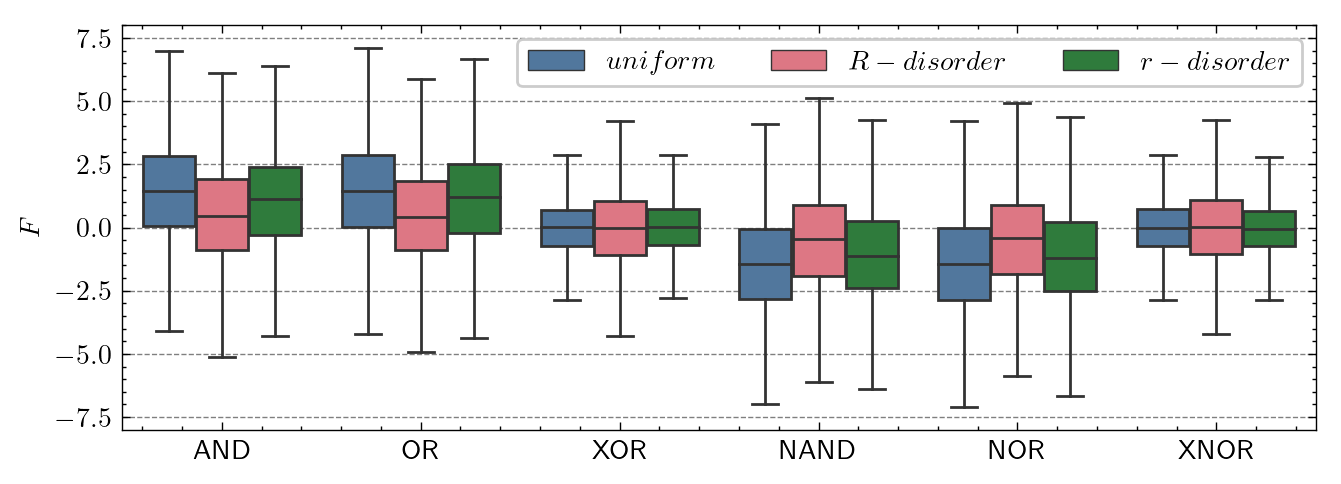

In [7]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2.2)
    
    ax  = fig.add_subplot()
    ax  = sns.boxplot(data=fitness_combined, x='Gate', y='$F$',hue='Disorder', ax=ax, fliersize=0)
    
    ax.set_ylim(-8,8)
    ax.set_xticklabels(gates)
    ax.set_xlabel("")
    ax.legend(title='', ncol=3, loc='upper right')

---

In [8]:
# Current Relations
params      = nanonets_utils.nonlinear_parameter(df=df)
params_res  = nanonets_utils.nonlinear_parameter(df=df_res)
params_rad  = nanonets_utils.nonlinear_parameter(df=df_rad)

# NDR
Q_ndr_l = nanonets_utils.return_ndr(params['Ml'])
Q_ndr_r = nanonets_utils.return_ndr(params['Mr'])
Q_ndr   = (Q_ndr_l + Q_ndr_r)/2

Q_ndr_l_res = nanonets_utils.return_ndr(params_res['Ml'])
Q_ndr_r_res = nanonets_utils.return_ndr(params_res['Mr'])
Q_ndr_res   = (Q_ndr_l_res + Q_ndr_r_res)/2

Q_ndr_l_rad = nanonets_utils.return_ndr(params_rad['Ml'])
Q_ndr_r_rad = nanonets_utils.return_ndr(params_rad['Mr'])
Q_ndr_rad   = (Q_ndr_l_rad + Q_ndr_r_rad)/2

# NLS
bins        = 500
Q_nls       = nanonets_utils.return_nls(df=params, bins=bins)
Q_nls_res   = nanonets_utils.return_nls(df=params_res, bins=bins)
Q_nls_rad   = nanonets_utils.return_nls(df=params_rad, bins=bins)

# DataFrame
df_Q        = pd.DataFrame(np.array([['$uniform$','$R-disorder$','$r-disorder$'],[Q_ndr, Q_ndr_res, Q_ndr_rad],[Q_nls, Q_nls_res, Q_nls_rad]]).T, columns=['Disorder','NDR','NLS'])
df_Q        = pd.melt(df_Q, var_name='Type', value_name='Q', value_vars=['NDR','NLS'], id_vars=['Disorder'])
df_Q['Q']   = pd.to_numeric(df_Q['Q'])

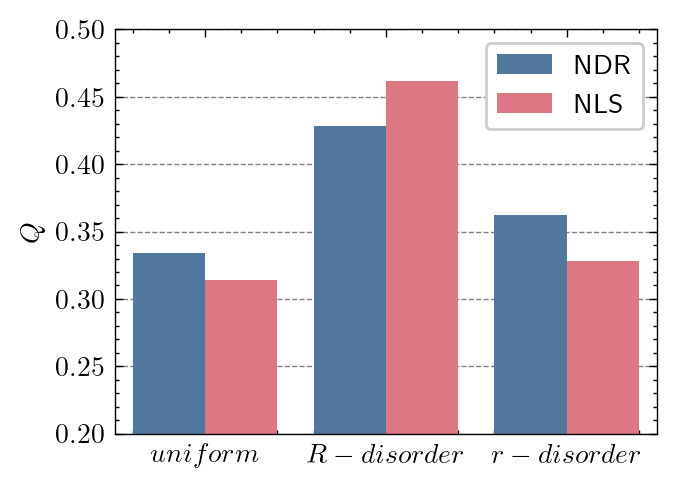

In [9]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.barplot(df_Q, x='Disorder', y='Q', hue='Type', ax=ax, dodge=True)

    ax.set_ylabel("$Q$")
    ax.set_xlabel("")
    ax.legend(title='')
    ax.set_ylim(0.2,0.5)

---

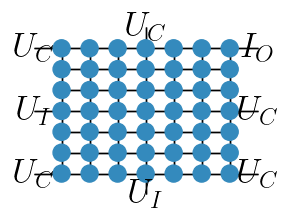

In [15]:
network_topology    = "cubic"
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[6,0,0],[0,3,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
node_size           = np.repeat(150, 49+8)
seed                = 2
rs                  = np.random.RandomState(seed)

# for i in rs.choice(np.arange(1,48), 9, replace=False):
#     node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size,
                                         provide_electrode_labels=["$U_C$","$U_I$","$U_C$","$U_I$","$U_C$","$U_C$","$U_C$","$I_O$"], font_size=25)
fig.savefig(f"plots/network_plot_r{0}.svg", transparent=True, bbox_inches='tight')

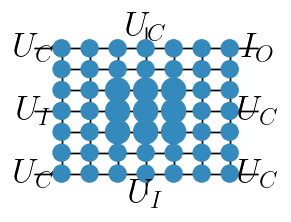

In [20]:
network_topology    = "cubic"
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[6,0,0],[0,3,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
node_size           = np.repeat(150, 49+8)
seed                = 2
rs                  = np.random.RandomState(seed)

for i in [16,17,18,23,24,25,30,31,32]:
    node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size,
                                         provide_electrode_labels=["$U_C$","$U_I$","$U_C$","$U_I$","$U_C$","$U_C$","$U_C$","$I_O$"], font_size=25)
fig.savefig(f"plots/network_plot_r{0}.svg", transparent=True, bbox_inches='tight')

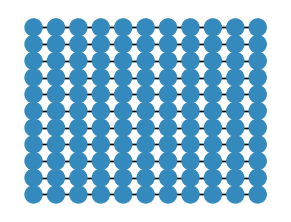

In [27]:
N = 11
network_topology    = "cubic"
topology_parameter  = {
    "Nx"    : N,
    "Ny"    : N,
    "Nz"    : 1,
    "e_pos" : []
}

np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
node_size           = np.repeat(150, N*N)
seed                = 2
rs                  = np.random.RandomState(seed)

# for i in [16,17,18,23,24,25,30,31,32]:
#     node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, font_size=25)
fig.savefig(f"plots/network_plot_size_5.svg", transparent=True, bbox_inches='tight')

In [3]:
df_base                 = pd.read_csv("/home/jonas/phd/data/system_size/scaled/Nx=7_Ny=7_Nz=1_Ne=8.csv")
df_radius               = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/radius/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_radius_s_corr        = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/radius_s_corr/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_resistance           = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/resistance/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}
df_resistance_s_corr    = {i : pd.read_csv(f"/home/jonas/phd/data/disorder/resistance_s_corr/Nx=7_Ny=7_Nz=1_Ne=8_th={i}.csv") for i in range(36)}

In [4]:
df_base                 = rename_df(df_base)
df_radius               = rename_df_in_dic(df_radius)
df_radius_s_corr        = rename_df_in_dic(df_radius_s_corr)
df_resistance           = rename_df_in_dic(df_resistance)
df_resistance_s_corr    = rename_df_in_dic(df_resistance_s_corr)

In [5]:
fitness_base                = nanonets_utils.fitness(df=df_base, N_controls=5, delta=0)
fitness_radius              = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_radius.items()}
fitness_radius_s_corr       = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_radius_s_corr.items()}
fitness_resistance          = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_resistance.items()}
fitness_resistance_s_corr   = {i : nanonets_utils.fitness(df=df, N_controls=5, delta=0) for i, df in df_resistance_s_corr.items()}

In [6]:
fitness_base["dis"] = "standard"

df = fitness_base.copy()
df = combine_df_dic(df, fitness_radius, "radius", "dis")
df = combine_df_dic(df, fitness_radius_s_corr, "radius_s_corr", "dis")
df = combine_df_dic(df, fitness_resistance, "resistance", "dis")
df = combine_df_dic(df, fitness_resistance_s_corr, "resistance_s_corr", "dis")

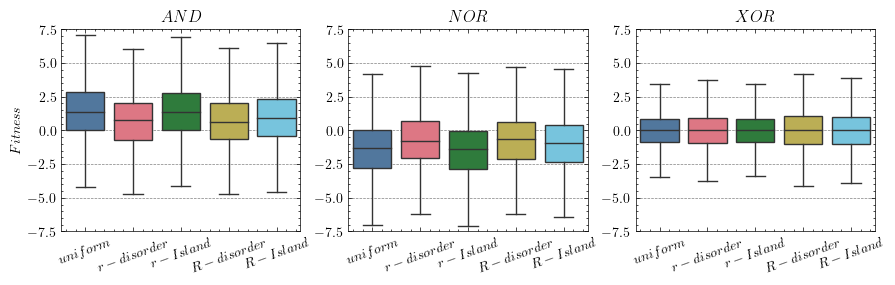

In [12]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth()*3)

    for i, gate in enumerate(["AND","NOR","XOR"]):

        ax  = fig.add_subplot(1,3,i+1)
        ax  = sns.boxplot(data=df, x='dis', y=f'{gate} Fitness', ax=ax, fliersize=0)
        ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)
        ax.set_xlabel("")

        if i == 0:
            ax.set_ylabel("$Fitness$")
        else:
            ax.set_ylabel("")

        ax.set_ylim(-7.5,7.5)
        ax.set_title(f"${gate}$")
    
    fig.savefig('plots/gate_fitness.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/gate_fitness.pdf', bbox_inches='tight', transparent=False)

In [8]:
ndr_base                = nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df_base)['Ml'],nanonets_utils.nonlinear_parameter(df_base)['Mr']]).values)
ndr_radius              = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_radius.items()]
ndr_radius_s_corr       = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_radius_s_corr.items()]
ndr_resistance          = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_resistance.items()]
ndr_resistance_s_corr   = [nanonets_utils.return_ndr(pd.concat([nanonets_utils.nonlinear_parameter(df)['Ml'],nanonets_utils.nonlinear_parameter(df)['Mr']])) for i, df in df_resistance_s_corr.items()]

In [9]:
nls_base              = nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df_base))
nls_radius            = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_radius.items()]
nls_radius_s_corr     = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_radius_s_corr.items()]
nls_resistance        = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_resistance.items()]
nls_resistance_s_corr = [nanonets_utils.return_nls(nanonets_utils.nonlinear_parameter(df)) for i, df in df_resistance_s_corr.items()]

/tmp/ipykernel_1770876/2490546418.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)


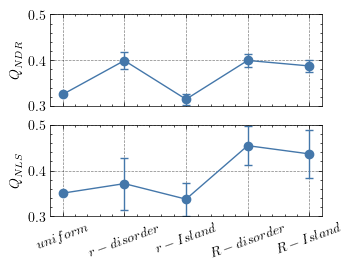

In [10]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure()
    ax  = fig.add_subplot(2,1,1)
    
    ax.errorbar(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"],
                [ndr_base, np.mean(ndr_radius), np.mean(ndr_radius_s_corr), np.mean(ndr_resistance), np.mean(ndr_resistance_s_corr)],
                [0, np.std(ndr_radius), np.std(ndr_radius_s_corr), np.std(ndr_resistance), np.std(ndr_resistance_s_corr)],
                marker='o', capsize=3)
        
    ax.set_xticklabels("", rotation=20)
    ax.set_ylabel("$Q_{NDR}$")
    ax.set_ylim(0.3,0.5)

    ax  = fig.add_subplot(2,1,2)
    ax.errorbar(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"],
                [nls_base, np.mean(nls_radius), np.mean(nls_radius_s_corr), np.mean(nls_resistance), np.mean(nls_resistance_s_corr)],
                [0, np.std(nls_radius), np.std(nls_radius_s_corr), np.std(nls_resistance), np.std(nls_resistance_s_corr)],
                marker='o', capsize=3)
    ax.set_xticklabels(["$uniform$","$r-disorder$","$r-Island$","$R-disorder$","$R-Island$"], rotation=20)
    ax.set_ylabel("$Q_{NLS}$")
    ax.set_ylim(0.3,0.5)

    fig.savefig('plots/nonlinear_metrics.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/nonlinear_metrics.pdf', bbox_inches='tight', transparent=False)